<a href="https://colab.research.google.com/github/arman690/Deep-learning-with-PyTorch---Image-Segmentation/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**1. Setup Environment and Install Libraries**

**Explanation**: Install the required libraries for segmentation and data augmentation.
python

In [5]:
!pip install segmentation-models-pytorch
!pip install albumentations==0.4.6  --upgrade
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=579390f4fdf8238116d2b5b58c4fc12682a7f0641aeb67a29806028e40110820
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=43dc2f91a7a899541732be3defcaf473cbdd54fe75642112c8c2545c75d1898a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

##**2. Clone the Dataset Repository**

**Explanation**: Clone the dataset repository to use for training and testing the segmentation model.


In [6]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 17.54 MiB/s, done.
Resolving deltas: 100% (3/3), done.


# 3. Import Libraries and Set Up Path

**Explanation**: Import essential libraries for deep learning, computer vision, and data manipulation. We also add the dataset path to the Python environment to make sure all helper functions are accessible.

In [7]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset')
import torch
import cv2

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import helper

# 4. Set Parameters and Load Dataset
 **Explanation**: Define key parameters like the number of epochs, learning rate, image size, and batch size. Set up the encoder and pretrained weights, which are essential for transfer learning. Finally, load the dataset CSV to preview the data.


In [9]:
# Define file paths and directories
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

# Define training parameters
DEVICE = 'cuda'  # Use GPU if available
EPOCHS = 25  # Number of training epochs
LR = 0.003  # Learning rate
IMAGE_SIZE = 320  # Image input size for the model
BATCH_SIZE = 16  # Number of images per batch

# Encoder and pretrained weights
ENCODER = 'efficientnet-b0'  # Encoder for the segmentation model
WEIGHTS = 'imagenet'  # Pretrained weights on ImageNet

In [10]:
# Load the dataset CSV to check initial rows
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


# 5. Load and Preprocess a Sample Image and Mask
**Explanation**: We load the path for an image and its corresponding mask from the dataset. Then, we read the image and convert its color format from BGR to RGB. For the mask, we load it in grayscale mode and normalize it to a range between 0 and 1.


In [11]:
# Select the first row in the dataset to preview an image and its mask
row = df.loc[0]

# Paths to the image and mask
image_path = row.images
mask_path = row.masks

# Load and preprocess the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB format

# Load and normalize the mask
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0  # Grayscale and normalization


# 6. Display the Sample Image and Mask
**Explanation**: We use Matplotlib to plot the image and its corresponding mask side by side. This helps us visually inspect the data and ensure the image and mask are correctly aligned.

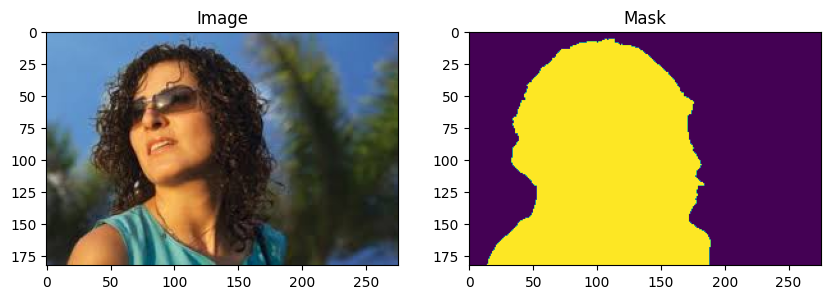

In [13]:
# Display image and mask side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Show image
ax1.set_title('Image')
ax1.imshow(image)

# Show mask
ax2.set_title('Mask')
ax2.imshow(mask)


# 7. Split the Dataset into Training and Validation Sets
**Explanation**: We use train_test_split from Scikit-Learn to divide the dataset into training and validation sets, with 80% of the data for training and 20% for validation. Setting a random seed ensures reproducibility.


In [14]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# 8. Define Data Augmentation for Training and Validation Sets
**Explanation**: We use albumentations for data augmentation. The get_train_augs function applies transformations like resizing, horizontal, and vertical flips to create variations in training images, helping the model generalize better. For validation, we only resize the images to match the input size of the model.


In [15]:
import albumentations as A

# Define training augmentations
def get_train_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),  # Resize images to match model input size
        A.HorizontalFlip(p=0.5),  # Randomly flip images horizontally
        A.VerticalFlip(p=0.5)  # Randomly flip images vertically
    ])

# Define validation augmentations
def get_valid_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),  # Resize images for validation
    ])


#Creat Custom Dataset

# 9. Define Custom Dataset Class for Segmentation
**Explanation**: We create a custom PyTorch Dataset class called segmentationDataset. This class loads images and masks from the provided DataFrame, applies augmentations, and normalizes the pixel values. Images and masks are then transformed into PyTorch tensors for use in training.

In [16]:
from torch.utils.data import Dataset

class segmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Get image and mask paths
        row = self.df.iloc[index]
        image_path = row.images
        mask_path = row.masks

        # Load and preprocess the image and mask
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)  # Add an extra dimension for mask

        # Ensure dimensions are consistent
        image = cv2.resize(image, (mask.shape[1], mask.shape[0]))

        if self.augmentations:
            # Apply augmentations without shape checking
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        # Transform image and mask to the correct format
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        # Normalize values
        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask


# 10. Initialize Training and Validation Datasets
**Explanation**: We create instances of the segmentationDataset class for both the training and validation sets. The training set uses augmentations defined in get_train_augs to improve model generalization, while the validation set only resizes images.


In [17]:
# Initialize training and validation datasets
trainset = segmentationDataset(train_df, get_train_augs())
validset = segmentationDataset(valid_df, get_valid_augs())

print(f'length of trainset : {len(trainset)}')
print(f'length of validset : {len(validset)}')

length of trainset : 232
length of validset : 58


# 11. Display a Sample Image and Mask from the Training Set
**Explanation**: We select an example from the training set, convert the image and mask tensors to NumPy arrays, and visualize them using Matplotlib to ensure the data has been correctly processed.


--2024-10-30 15:57:38--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2024-10-30 15:57:39 (51.4 MB/s) - ‘helper.py’ saved [2813/2813]



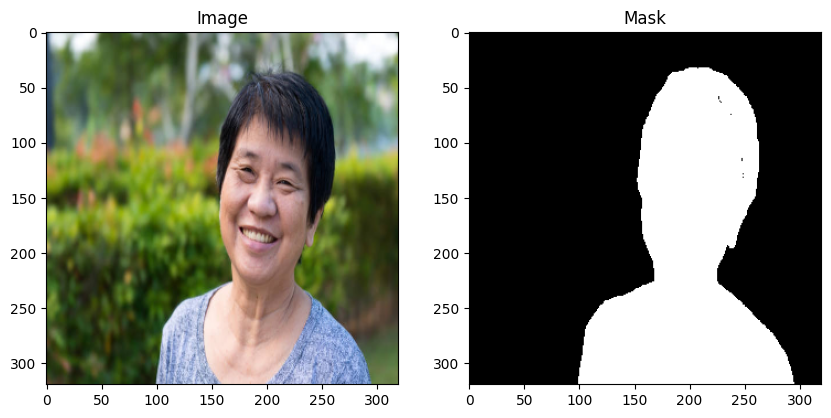

In [18]:
# Download helper functions if not already present
!wget -c https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
import helper

# Select a sample image and mask from the training set
idx = 3
image, mask = trainset[idx]

# Convert the image and mask tensors to NumPy arrays for display
image = image.numpy().transpose(1, 2, 0)  # Transpose for display
mask = mask.numpy().transpose(1, 2, 0).squeeze()  # Remove extra channel dimension for the mask

# Display the image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.show()


# 12. Set Up DataLoaders for Training and Validation
**Explanation**: Using PyTorch's DataLoader, we create loaders for both training and validation sets. The training loader is set to shuffle the data, ensuring varied batches in each epoch, while the validation loader reads data without shuffling.


In [19]:
from torch.utils.data import DataLoader

# Initialize DataLoaders for training and validation
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

# Check a sample batch from the trainloader
for image, mask in trainloader:
    print(image.shape)  # Output shape of image batch
    print(mask.shape)  # Output shape of mask batch
    break  # Check only the first batch


torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])


# 13. Define the Segmentation Model
**Explanation**: We define a custom model class, SegmentationModel, which leverages the Unet architecture from segmentation_models_pytorch. The model accepts images as input, and if masks are provided, it calculates a combined loss using Dice loss and binary cross-entropy. The output is either logits only or logits with loss for training.


In [20]:
from torch import nn
import segmentation_models_pytorch as smp

class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        # Define Unet model with specified encoder and weights
        self.arc = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None,  # No activation for output layer
        )

    def forward(self, images, masks=None):
        # Forward pass through the Unet architecture
        logits = self.arc(images)

        # If masks are provided, calculate loss
        if masks is not None:
            loss1 = smp.losses.DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2

        return logits


model = SegmentationModel()
model = model.to(DEVICE)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 37.6MB/s]


# 14. Define Training and Evaluation Functions
Explanation: The train_fn function performs one epoch of training, updating model parameters based on the calculated loss. The eval_fn function evaluates the model on the validation set without updating parameters.

In [21]:
from tqdm import tqdm

def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0

    # Training loop
    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        # Zero out gradients
        optimizer.zero_grad()

        # Forward pass and compute loss
        logits, loss = model(images, masks)

        # Backpropagation and optimizer step
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

def eval_fn(data_loader, model):
    model.eval()
    total_loss = 0

    # No gradient computation for evaluation
    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            # Forward pass and compute loss
            logits, loss = model(images, masks)

            total_loss += loss.item()

    return total_loss / len(data_loader)


# 15. Initialize the Optimizer
Explanation: We use the Adam optimizer, which is effective for deep learning tasks due to its adaptive learning rate for each parameter. The learning rate (LR) was set previously.

In [22]:
# Initialize the Adam optimizer with the specified learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


# 16. Training Loop with Model Checkpointing
Explanation: For each epoch, we calculate train_loss and valid_loss using the train_fn and eval_fn functions. If valid_loss improves compared to the best previous value, we save the model as a checkpoint. At the end of each epoch, we print the train_loss and valid_loss values.

In [23]:
best_valid_loss = np.Inf  # Initialize best validation loss as infinity
for epoch in range(EPOCHS):
    # Perform training and validation for the epoch
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)

    # Check if validation loss has improved
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pth')
        print('Saved model')
        best_valid_loss = valid_loss

    # Print training and validation loss for the current epoch
    print(f'Epoch: {epoch + 1} | Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}')


100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Saved model
Epoch: 1 | Train Loss: 0.8444 | Validation Loss: 1.9181


100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Saved model
Epoch: 2 | Train Loss: 0.3856 | Validation Loss: 0.9056


100%|██████████| 4/4 [00:00<00:00,  5.61it/s]


Epoch: 3 | Train Loss: 0.3350 | Validation Loss: 1.5329


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch: 4 | Train Loss: 0.3199 | Validation Loss: 1.2471


100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch: 5 | Train Loss: 0.2652 | Validation Loss: 0.9172


100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Saved model
Epoch: 6 | Train Loss: 0.2462 | Validation Loss: 0.5731


100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch: 7 | Train Loss: 0.2126 | Validation Loss: 0.5797


100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


Epoch: 8 | Train Loss: 0.1988 | Validation Loss: 0.5754


100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


Epoch: 9 | Train Loss: 0.1826 | Validation Loss: 0.7159


100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Saved model
Epoch: 10 | Train Loss: 0.1829 | Validation Loss: 0.4262


100%|██████████| 4/4 [00:00<00:00,  4.56it/s]


Saved model
Epoch: 11 | Train Loss: 0.1914 | Validation Loss: 0.3600


100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Saved model
Epoch: 12 | Train Loss: 0.1748 | Validation Loss: 0.3299


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


Saved model
Epoch: 13 | Train Loss: 0.1455 | Validation Loss: 0.3042


100%|██████████| 4/4 [00:00<00:00,  5.27it/s]


Saved model
Epoch: 14 | Train Loss: 0.1375 | Validation Loss: 0.2987


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Saved model
Epoch: 15 | Train Loss: 0.1321 | Validation Loss: 0.2651


100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch: 16 | Train Loss: 0.1519 | Validation Loss: 0.5130


100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch: 17 | Train Loss: 0.1449 | Validation Loss: 0.4534


100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch: 18 | Train Loss: 0.1509 | Validation Loss: 0.6590


100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


Epoch: 19 | Train Loss: 0.1387 | Validation Loss: 0.8155


100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch: 20 | Train Loss: 0.1284 | Validation Loss: 0.3273


100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch: 21 | Train Loss: 0.1358 | Validation Loss: 0.2958


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


Epoch: 22 | Train Loss: 0.1129 | Validation Loss: 0.3242


100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Saved model
Epoch: 23 | Train Loss: 0.1148 | Validation Loss: 0.2536


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Saved model
Epoch: 24 | Train Loss: 0.1429 | Validation Loss: 0.2060


100%|██████████| 4/4 [00:00<00:00,  5.52it/s]

Epoch: 25 | Train Loss: 0.1106 | Validation Loss: 0.2078


# 17. Inference Model Inference for Segmentation

In this cell, we perform inference on a single image from the validation set using our trained segmentation model. Here's a breakdown of each step:

1. **Load Model Weights**: We load the saved weights from the file `'best_model.pth'`, which were obtained from the best validation loss during training.

2. **Select Image and Mask**: We choose an image-mask pair from the validation set at a specified index (`idx = 12`).

3. **Generate Model Predictions**: The model processes the image and produces raw logits for each pixel. These logits represent the unbounded predictions before applying the sigmoid activation.

4. **Apply Sigmoid Activation**: We use the sigmoid function to convert the logits into probabilities for each pixel, where values range between 0 and 1.

5. **Binary Thresholding**: We apply a threshold (0.5) to convert the probabilities into a binary mask, classifying each pixel as either foreground (object) or background.

This process yields a binary mask that can be visualized to assess the model's segmentation performance on the selected validation image.


In [24]:
idx = 12
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = pred_mask.squeeze(0)  # Remove the batch dimension
pred_mask = (pred_mask > 0.5)

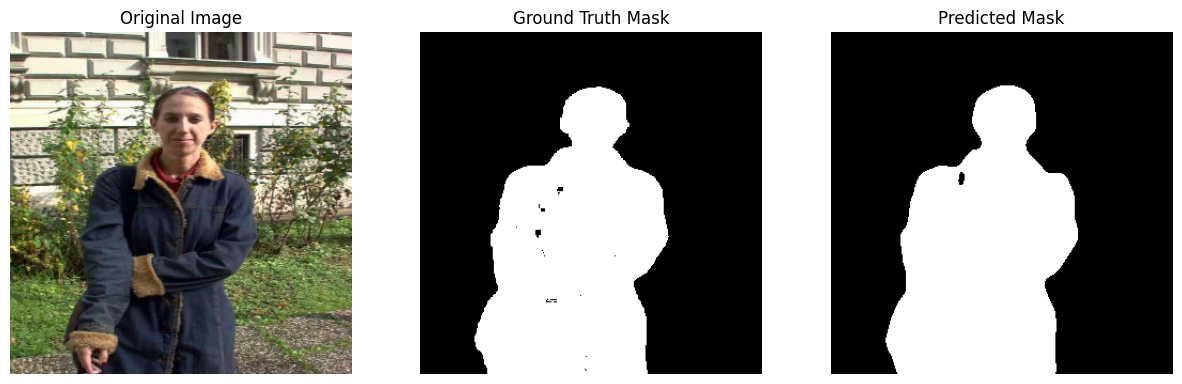

In [26]:
# Custom function to display image, mask, and prediction side-by-side
def show_image(image, mask, pred_mask):
    # Convert tensors to numpy arrays for visualization
    image_np = image.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    mask_np = mask.cpu().numpy().squeeze()             # Remove channel dim
    pred_mask_np = pred_mask.cpu().numpy().squeeze()    # Remove channel dim

    # Plot original image, ground truth mask, and predicted mask
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(mask_np, cmap='gray')
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    axes[2].imshow(pred_mask_np, cmap='gray')
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()

# Call the function with your data
show_image(image, mask, pred_mask)
